# Lab 03, Feb 12 2019.
### Due Feb 19, 2019, before lab.
### COMPAS Risk Score Analysis - Part II

In this lab, you will continue auditing the the COMPAS Risk Algorithm for notions of fairness. We will look more closely at the the false positive and true positive rates, and examine the thresholds at which separation is achievable.

Refer to the [Problem Set: Criminal justice case study](https://fairmlbook.org/demographic.html#problem-set-criminal-justice-case-study) in the "Fairness in ML" book. 
Also, feel free to consult the [notebook on the Adult Data Set](https://fairmlbook.org/code/adult.html) referred to in the text.

### Getting Started
To get started, like last time create a *Lab03* folder in your local repo alongwith a *data* folder. In the data folder, place the data file we will be using, which was obtained by ProPublica as a result of a public records request from Broward County, Florida. The csv file can be downloaded from [here](https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv). Place it in your *data* folder for *Lab03*. 

## *Note*: You may skip to the [section](http://localhost:8891/notebooks/Lab3/Lab03-key.ipynb#Lab-03-starts-here.) where your tasks for Lab 03 starts. Up until then, this is my version of a (part) solution to Lab 02.

In [5]:
%matplotlib inline

import pandas as pd
import pylab
import numpy as np
import seaborn as sns

import pylab
import numpy as np
import matplotlib.pyplot as plt

Loading the data

In [6]:

data = pd.read_csv('data/compas-scores-two-years.csv', index_col=0)

Now we will filter out rows where **days_b_screening_arrest** is over 30 or under -30, leaving us with 6,172 rows. 

In [7]:
#Filtering out data
filterData = data[(data['days_b_screening_arrest'] <= 30) & (data['days_b_screening_arrest'] >= -30)]

In [8]:
#checking if the data is the correct size
filterData.shape

(6172, 52)

Now, we'll go on to the 'Calibration/Sufficiency' part of the text's case study, that is: 
> Plot the fraction of defendants recidivating within two years (**two_year_recid == 1**) as a function of risk score (**decile_score**), for black defendants (**race == "African-American"**) and white defendants (**race == "Caucasian"**).

To achieve this, first construct a data frame that contains only these three features, that is, **two_year_recid**, **decile_score**, and **race**. Make it a habit to inspect the head or tail of this data frame.

In [9]:
#Answer here
feature_cols = ['two_year_recid', 'decile_score', 'race']
df = filterData[feature_cols]
df.shape
df.head()


,two_year_recid,decile_score,race
id,,,
1,0,1,Other
3,1,3,African-American
4,1,4,African-American
7,0,1,Other
8,1,6,Caucasian


Notice that each row falls in a **decile_score** bucket between 1 and 10. Now write the body of a function that given a dataframe, returns two lists (each of length 10). Each element of the first list corresponds to the number of people in the dataframe who have a specific decile score and for whom **two_year_recid == 1**. The corresponding element of the second list counts the total number of people with that decile score.

In [10]:

def get_frequencies(df, num_buckets=10, count_criterion = 'two_year_recid'):
    """Returns list of lists. The first list is successes 
    for all buckets, the second one is total counts."""
    
    frequencies = [[],[]]
    # Answer here
    for i in range(num_buckets):
        a = df[df['decile_score'] == i+1]
        current_recid = a[count_criterion]
        total = len(current_recid)
        success = len(a[a[count_criterion] == 1])
        frequencies[0].append(success)
        frequencies[1].append(total)
        
    return frequencies

In [11]:
# Setting up things to plot

races = ['African-American', 'Caucasian']
styles = ['-', '--']
colors = ['g', 'b']
deciles = range(1, 10+1)
pylab.rc('font',  size='17')
pylab.rc('axes', labelsize='large')
pylab.rc('lines', linewidth=3)

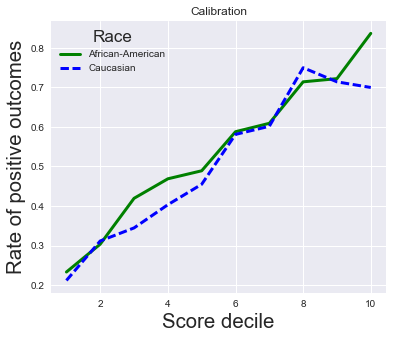

In [12]:


#Setting up the figure, size and title.
pylab.figure(1, figsize=(6, 5))
pylab.title('Calibration')

#For both races, plot the proportion 
# of successes versus the deciles


for i in range(2):
    race = races[i]
    num = get_frequencies(df[df['race']== race])
    n_succs, n_obss = np.array(num[0]), np.array(num[1])
    pylab.plot(deciles, n_succs / n_obss,  label=race, linestyle = styles[i], color = colors[i])

#Setting up the legend, and other labels.

pylab.legend(title="Race")
pylab.ylabel('Rate of positive outcomes')
pylab.xlabel('Score decile')


In [13]:
# This plot uses the python package proportion
# and employs confidence intervals

from statsmodels.stats import proportion

def plot_confidence(plt, xs, n_succs, n_obss, label, linestyle, color, confidence=0.95):
    """Plot a graph with confidence intervals where
       each x corresponds to a binomial random variable in which n_obs observations led to n_succ successes"""
    n_succs, n_obss = np.array(n_succs), np.array(n_obss)
    conf_lbs, conf_ubs = proportion.proportion_confint(n_succs, n_obss, alpha=1-confidence)
    pylab.fill_between(xs, conf_ubs, conf_lbs, alpha=.2, color=color)
    pylab.plot(xs, n_succs / n_obss, '.-', label=label, linestyle=linestyle, color=color)

Now, we go on to the next part, which is examining the Separation criterion.

> Plot the distribution of scores received by the positive class (recidivists) and the distribution of scores received by the negative class (non-recidivists) for black defendants and for white defendants.



In [14]:
# new dataframe of black defendants only
black = df[df['race']=='African-American']

#new dataframe of white defendants only
white = df[df['race']=='Caucasian']

# get the frequency of black defendants who did recidivate by score 
freq_black = get_frequencies(black, num_buckets=10, count_criterion = 'two_year_recid')

# get the frequency of black white defendants who did recidivate by score 
freq_white = get_frequencies(white, num_buckets=10, count_criterion = 'two_year_recid')



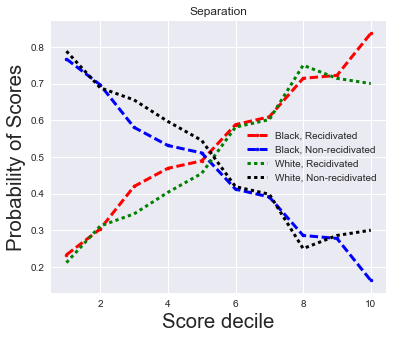

In [15]:
# 
pylab.figure(3, figsize=(6, 5))
pylab.title('Separation')

pylab.plot(deciles, np.array(freq_black[0]) / np.array(freq_black[1]), '.-', label="Black, Recidivated", linestyle = '--', color = "red")
pylab.plot(deciles, (np.array(freq_black[1]) - np.array(freq_black[0])) / np.array(freq_black[1]), '.-', label="Black, Non-recidivated", linestyle = '--', color = "blue")
pylab.plot(deciles, np.array(freq_white[0]) / np.array(freq_white[1]),  label="White, Recidivated", linestyle = ':', color = "green")
pylab.plot(deciles, (np.array(freq_white[1]) - np.array(freq_white[0])) / np.array(freq_white[1]), label="White, Non-recidivated", linestyle = ':', color = "black")

pylab.legend()

pylab.ylabel('Probability of Scores')
pylab.xlabel('Score decile')

## <span style="color:blue">*Lab 03* starts here</span>.
In this lab, we will tackle the following parts of the case study:
> Report the Positive Predictive Value, False Positive Rate, and False Negative Rate for a risk threshold of 4 (i.e., defendants with decile_score >= 4 are classified as high risk), for black defendants and for white defendants.

**Task 1**: To achieve this use a threshold of 4, and designate anyone who scores 4 and below as low-risk. Designate anyone with a score of 5 and above as high risk. Now, for black defendants, compute the [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/), which consists of computing the following: 
- the number of **false negatives**, that is the number of black defendants who recidivated but got assigned a low score.
- **true positives**, that is, the number of black defendants who recidivated and got assigned a high score.
- **false positive**, that is, those who did not recidivate but got assigned a high score.
- **true negative**, that is, those who did not recidivate and got assigned a low score.


Fill in the details of the code below.


In [16]:



# they were high risk and they did recidvate
TP_black = 

# they were deemed low risk but did recividate
FN_black = 
# they were deemed low risk and they did not recidivate 
TN_black = 

# they were deemed high risk and they did not recidivate
FP_black = 




**Task 2:** Repeat the process for white defendants.

In [17]:
# My answer here

# they were high risk and they did recidvate
TP_white = 

#they were deemed low risk but did recividate
FN_white = 

# they were deemed low risk and they did not recidivate 
TN_white = 

# they were deemed high risk and they did not recidivate
FP_white = 


**Task 3** Now, display the confusion matrix, and compute the **false positive rates (FPR)**, **false negative rates (FNR)**, and the **positive predictive rates (PPR)** for black and white defendants. Review the definition of these rates either from the slides or the text. 

See my output for an example.

Threshold:  4
 Black defendants
----------------------------------------
Recidivated?| Low score| High Score   
----------------------------------------
Yes         | 473        | 1188          
No          |873       | 641          
FPR: Black 0.4233817701453104
FNR: Black 0.2847682119205298
PPR: Black 0.6495352651722253

 White defendants
----------------------------------------
Recidivated?| Low score| High Score   
----------------------------------------
Yes         |408       | 414          
No          |999       | 282          
FPR 0.22014051522248243
FNR 0.49635036496350365
PPR: White 0.5948275862068966



So, far we used a threshold of 4 to decide whether a defendant is low risk or not. Now, we will examine different thresholds and compare the impact on FPRs and FNRs of black and white defendants.

**Task 4:** To achieve this, write a function that takes in the threshold, the distribution of black defendants who did (and did not) recidivate by score, and the distribution of white defendants who did (and did not) recidivate by score. In my case, these two distributions are in the variables **freq_black** and **freq_white**. The function should return the FPRs, FNRs and the PPRs for that threshold for both black and white defendants. Below, is a sketch of my function, that you can feel free to use or ignore.


In [31]:


def threshold_to_rates(threshold, freq_black, freq_white, print_values = 1):
    
    # your answer here
    
    # if you want to print the confusion matrix and the rates
    if (print_values == 1):
        print("Threshold: ", threshold)
        print(" Black defendants")
        print("----------------------------------------")
        print( "Recidivated?| Low score| High Score   " )
        print("----------------------------------------")
        print("Yes         |", FN_black, "       | "+ str(TP_black) +"          ")
        #print("No           |  TN_black         |  FP_black          ")
        print("No          |"+ str(TN_black)+ "       | "+ str(FP_black) +"          ")
        print('FPR: Black', FPR_black)
        print('FNR: Black', FNR_black )
        print('PPR: Black',PPR_black )
        print()
        
        print(" White defendants")
        print("----------------------------------------")
        print( "Recidivated?| Low score| High Score   " )
        print("----------------------------------------")
        print("Yes         |"+ str(FN_white)+ "       | "+ str(TP_white) +"          ")
        #print("No           |  TN_black         |  FP_black          ")
        print("No          |"+ str(TN_white)+ "       | "+ str(FP_white) +"          ")
        print('FPR', FPR_white )
        print('FNR', FNR_white)
        print('PPR: White', PPR_white )
        print()
    
    
    #return the rates
    rates_white = [FPR_white, FNR_white, PPR_white]
    rates_black = [FPR_black, FNR_black, PPR_black]
    return [ rates_white, rates_black]


**Task 5:** Now, write code to create a two dimensional numpy array, **rates_thresh_black** such that the first column is the list of all thresholds (from 1 to 9), the second column the corresponding FPRs for black defendants corresponding to these thresholds, the third column the corresponding FNRs, and the fourth column the PPRs. Repeat this process for white defendants.

In [35]:

# Your answer here
# the first column is the threshold
# the second column the FPR
# the third colum the FNR
# the fourth colum the PPR

    

**Task 6: ** Assuming the arrays are **FP_rates_black**, **FN_rates_black**, **FP_rates_whites**, and **FN_rates_white**, the code below plots the **FN Rates** vs the **FP Rates** and marks the points corresponding to the thresholds. Notice, that this is essentially the ROC curve, except that we are using False Negative Rate which is 1 - True Positive Rate. Essentially, use your FPRs and FNRs to create your plot, and compare it to my results.

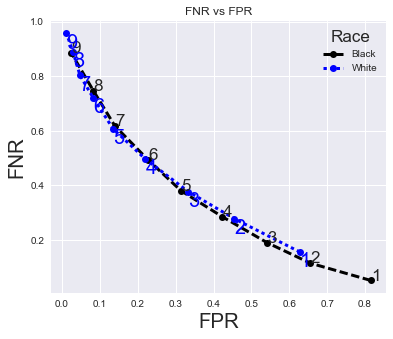

In [40]:
pylab.figure(5, figsize=(6, 5))
pylab.title('FNR vs FPR')

pylab.plot(FP_rates_black, FN_rates_black,  '.-', label="Black", marker ='o', linestyle = '--', color = "black")
for i, txt in enumerate(range(1,10)):
    pylab.annotate(txt, (FP_rates_black[i], FN_rates_black[i]))
pylab.plot(FP_rates_white, FN_rates_white,':', label="White", marker = 'o', linestyle = ':', color = "blue")
for i, txt in enumerate(range(1,10)):
    pylab.annotate(txt, (FP_rates_white[i], FN_rates_white[i]), horizontalalignment='left', verticalalignment='top',
            fontsize=20, color = "blue")

pylab.legend(title="Race")

pylab.ylabel('FNR')
pylab.xlabel('FPR')

**Task 7:** Now, answer the following question:
> Can we pick two thresholds (one for black defendants, one for white defendants) such that FPR and FNR are roughly equal for the two groups (say, within 1% of each other)? What is the PPV for the two groups in this case? Note: trivial thresholds of 0 or 11 don’t count.

**Task 8:** Finally, report the recidivism rate of defendants aged 25 or lower, and defendants aged 50 or higher. Note the stark difference between the two: younger defendants are far more likely to recidivate.


**Task 9:** Now, answer the following questions to the best of your ability. These questions don't have a single correct answer - we will use your responses as an input to a class discussion on the relationship between auditing a scoring process for fairness and the underlying societal contexts in which they are used.

> Suppose we are interested in taking a data-driven approach to changing the criminal justice system. Under a theory of incarceration as incapacitation (prevention of future crimes by removal of individuals from society), how might we act on the finding that younger defendants are more likely to reoffend?


> How might we act on this finding under a rehabilitative approach to justice, in which we seek to find interventions that minimize a defendant’s risk of recidivism?

> Under a retributive theory of justice, punishment is based in part on culpability, or blameworthiness; this in turn depends on how much control the defendant had over their actions. Under such a theory, how might we act on the finding that younger defendants are more likely to reoffend (and, more generally, commit offenses at all)?